In [32]:
import cv2
import numpy as np 
import os
from random import shuffle
from tqdm import tqdm


In [69]:
train = "C:/Users/ksaja/Desktop/SiviQuestion(internship)/train1"
test = "C:/Users/ksaja/Desktop/SiviQuestion(internship)/test"


IMG_SIZE = 256
LR = 1e-3

MODEL_NAME = 'humanvsnothuman-{}-{}.model'.format(LR, '2conv-basic')

In [70]:
def label_img(img):
    word_label = img.split('.')[-3]
    
    if word_label == 'Not_human': return [1,0]
                              
    elif word_label == 'human': return [0,1]

In [71]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(train)):
        label = label_img(img)
        path = os.path.join(train,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [50]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(test)):
        path = os.path.join(test,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

train_data = create_train_data()

100%|████████████████████████████████████████████████████████████████████████████| 24999/24999 [06:44<00:00, 61.84it/s]


In [77]:
import tensorflow as tf
tf.reset_default_graph()

In [78]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]



In [79]:

model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1914  | total loss: 0.06945 | time: 39.211s
| Adam | epoch: 005 | loss: 0.06945 - acc: 0.9958 -- iter: 24448/24499
Training Step: 1915  | total loss: 0.06258 | time: 40.320s
| Adam | epoch: 005 | loss: 0.06258 - acc: 0.9962 | val_loss: 0.00208 - val_acc: 1.0000 -- iter: 24499/24499
--


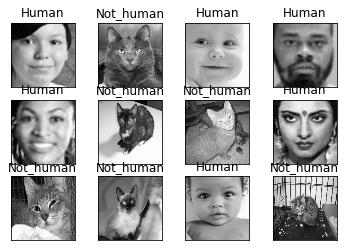

In [80]:
import matplotlib.pyplot as plt

test_data = np.load('C:/Users/ksaja/Desktop/SiviQuestion(internship)/train_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Human'
    else: str_label='Not_human'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()